In [1]:
#Spider onsite

In [2]:
#importing all required model
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os
from PIL import Image
from matplotlib import pyplot as plt



2024-08-15 12:44:43.660621: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 12:44:43.660727: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 12:44:43.787602: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
classes = pd.read_csv('/kaggle/input/wikiart/classes.csv')
print(classes.head())
length = len(classes)
print(length)

                                            filename         artist  \
0  Abstract_Expressionism/aaron-siskind_acolman-1...  aaron siskind   
1  Abstract_Expressionism/aaron-siskind_chicago-6...  aaron siskind   
2  Abstract_Expressionism/aaron-siskind_glouceste...  aaron siskind   
3  Abstract_Expressionism/aaron-siskind_jerome-ar...  aaron siskind   
4  Abstract_Expressionism/aaron-siskind_kentucky-...  aaron siskind   

                        genre          description             phash  width  \
0  ['Abstract Expressionism']       acolman-1-1955  bebbeb018a7d80a8   1922   
1  ['Abstract Expressionism']       chicago-6-1961  d7d0781be51fc00e   1382   
2  ['Abstract Expressionism']  gloucester-16a-1944  9f846e5a6c639325   1382   
3  ['Abstract Expressionism']  jerome-arizona-1949  a5d691f85ac5e4d0   1382   
4  ['Abstract Expressionism']      kentucky-4-1951  880df359e6b11db1   1382   

   height  genre_count subset  
0    1382            1  train  
1    1746            1  train  
2 

In [4]:
wclasses = pd.read_csv('/kaggle/input/wikiart/wclasses.csv')
wclasses.head()

,file,artist,genre,style
0,Realism/vincent-van-gogh_pine-trees-in-the-fen...,22,133,161
1,Baroque/rembrandt_the-angel-appearing-to-the-s...,20,136,144
2,Post_Impressionism/paul-cezanne_portrait-of-th...,16,135,160
3,Impressionism/pierre-auguste-renoir_young-girl...,17,131,152
4,Romanticism/ivan-aivazovsky_morning-1851.jpg,9,139,163


In [5]:
import os
import pandas as pd
from tqdm import tqdm
import csv

data = []
root_directory = '/kaggle/input/wikiart/Early_Renaissance'

for dirpath, dirnames, filenames in os.walk(root_directory):
    for file_name in tqdm(filenames, desc="Processing files"):
        file_path = os.path.join(dirpath, file_name)
        try:
            with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
                content = file.read()
            data.append([file_path, content])
        except UnicodeDecodeError as e:
            print(f"Unicode error for file {file_path}: {e}")
            continue  

df = pd.DataFrame(data, columns=['File Path', 'Content'])

output_csv = '/kaggle/working/all_file_contents.csv'
df.to_csv(output_csv, index=False, escapechar='\\', quoting=csv.QUOTE_MINIMAL)

print(f'All file contents saved to {output_csv}')


Processing files: 100%|██████████| 1391/1391 [00:23<00:00, 59.27it/s]


All file contents saved to /kaggle/working/all_file_contents.csv


In [6]:
df.head()

,File Path,Content
0,/kaggle/input/wikiart/Early_Renaissance/domeni..., JFIF       C \t\t\n \n ...
1,/kaggle/input/wikiart/Early_Renaissance/fra-an..., JFIF       C \t\t\n \n ...
2,/kaggle/input/wikiart/Early_Renaissance/benozz..., JFIF       C \t\t\n \n ...
3,/kaggle/input/wikiart/Early_Renaissance/carlo-..., JFIF       C \t\t\n \n ...
4,/kaggle/input/wikiart/Early_Renaissance/pietro..., JFIF       C \t\t\n \n ...


In [7]:
class ImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith(('jpg', 'png', 'jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image

image_dir = '/kaggle/input/wikiart/Early_Renaissance'

# Define transformations: resize, convert to tensor, normalize
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1] range
])

# Create the dataset and dataloader
dataset = ImageDataset(image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)




In [8]:
len(dataloader)
#44*32 == 1408

44

In [9]:
image, *_ = next(iter(dataloader))
image

tensor([[[-0.3569, -0.3804, -0.3333,  ..., -0.2549, -0.2392, -0.2392],
         [-0.3176, -0.3490, -0.3490,  ..., -0.3098, -0.2863, -0.3020],
         [-0.3569, -0.3804, -0.4353,  ..., -0.2471, -0.2549, -0.3255],
         ...,
         [-0.4353, -0.4353, -0.4353,  ..., -0.5843, -0.6078, -0.5373],
         [-0.4824, -0.4902, -0.4745,  ..., -0.4745, -0.5294, -0.4745],
         [-0.4824, -0.4745, -0.3647,  ..., -0.2235, -0.2235, -0.3255]],

        [[-0.4588, -0.4745, -0.4510,  ..., -0.4510, -0.4431, -0.4431],
         [-0.4431, -0.4510, -0.4588,  ..., -0.4980, -0.4745, -0.4824],
         [-0.4824, -0.5059, -0.5373,  ..., -0.4510, -0.4510, -0.4902],
         ...,
         [-0.5451, -0.5765, -0.5686,  ..., -0.6392, -0.6471, -0.6157],
         [-0.5529, -0.5686, -0.5451,  ..., -0.5843, -0.6000, -0.5686],
         [-0.5294, -0.4902, -0.4353,  ..., -0.3490, -0.3804, -0.4118]],

        [[-0.5529, -0.5529, -0.5373,  ..., -0.5529, -0.5451, -0.5373],
         [-0.5373, -0.5451, -0.5529,  ..., -0

In [10]:
def weights_init(m):
    """
    Takes as input a neural network m that will initialize all its weights.
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [11]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(100, 512, 4, 1, 0, bias=False),  # Output: (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # Output: (64, 32, 32)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),     # Output: (3, 64, 64)
            nn.Tanh()
        )
        
    def forward(self, input):
        return self.main(input)

# Initialize the Generator
gen = Generator()





In [12]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),  # Output: (64, 32, 32)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),  # Output: (128, 16, 16)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),  # Output: (256, 8, 8)
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),  # Output: (512, 4, 4)
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),  # Output: (1, 1, 1)
            nn.Sigmoid()
        )
        
    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1)  # Ensure the output shape is (batch_size, 1)

# Initialize the Discriminator
dis = Discriminator()




In [13]:
EPOCH = 3
LR = 0.001
criterion = nn.BCELoss()
optimizerD = optim.Adam(dis.parameters(), lr=LR, betas=(0.5, 0.999))
optimizerG = optim.Adam(gen.parameters(), lr=LR, betas=(0.5, 0.999))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gen = gen.to(device)
dis = dis.to(device)

loss_G_list = []
loss_D_list = []

# Training loop
for epoch in range(EPOCH):
    for i, real_images in enumerate(dataloader):
        
        
        real_images = real_images.to(device)

        
        real_labels = torch.ones(real_images.size(0), 1).to(device)
        fake_labels = torch.zeros(real_images.size(0), 1).to(device)

        
        dis.zero_grad()

        # Real images
        outputs = dis(real_images)
        loss_real = criterion(outputs, real_labels)
        loss_real.backward()

        # Fake images
        noise = torch.randn(real_images.size(0), 100, 1, 1).to(device)
        fake_images = gen(noise)
        outputs = dis(fake_images.detach())
        loss_fake = criterion(outputs, fake_labels)
        loss_fake.backward()
        
        optimizerD.step()

        
        loss_D = loss_real + loss_fake

       #generator training
        gen.zero_grad()
        outputs = dis(fake_images)
        loss_G = criterion(outputs, real_labels)  
        loss_G.backward()

        optimizerG.step()
        
        
        loss_G_list.append(loss_G.item())
        loss_D_list.append(loss_D.item())

        if i % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCH}], Step [{i}/{len(dataloader)}], '
                  f'D Loss: {loss_D.item():.4f}, G Loss: {loss_G.item():.4f}')


Epoch [1/3], Step [0/44], D Loss: 1.3779, G Loss: 11.8772
Epoch [2/3], Step [0/44], D Loss: 1.1436, G Loss: 1.7159
Epoch [3/3], Step [0/44], D Loss: 0.7986, G Loss: 3.2331


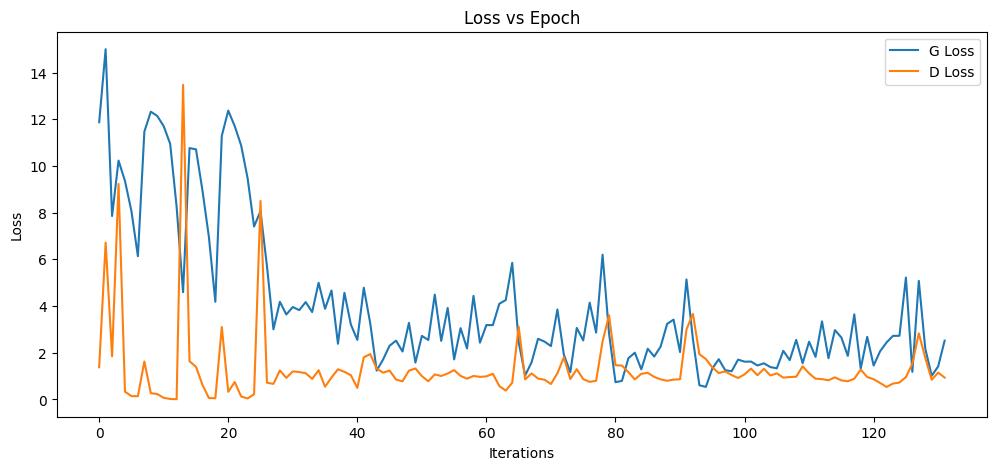

In [14]:
def plot_loss(loss_G, loss_D):
    plt.figure(figsize=(12,5))
    plt.title("Loss vs Epoch")
    plt.plot(loss_G, label="G Loss")
    plt.plot(loss_D, label="D Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Plot the losses
plot_loss(loss_G_list, loss_D_list)
    


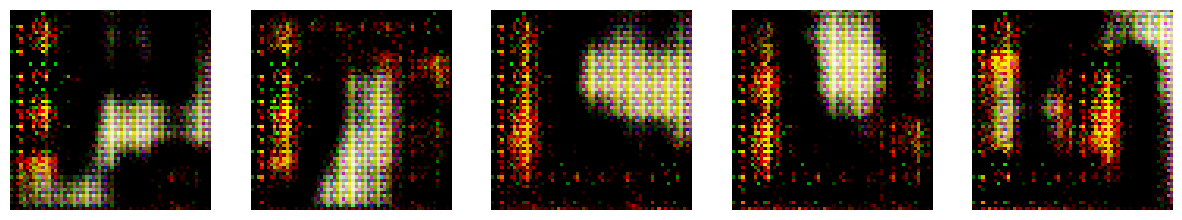

In [15]:
def show_generated_img(n_images=5):
    sample = []
    
    for _ in range(n_images):
        
        noise = torch.randn(1, 100, 1, 1, device=device)
        
        
        gen_image = gen(noise).to("cpu").clone().detach().squeeze(0)
        
        
        gen_image = gen_image.numpy().transpose(1, 2, 0)  
        sample.append(gen_image)
    
    
    figure, axes = plt.subplots(1, len(sample), figsize=(15, 15))  
    
    
    for index, axis in enumerate(axes):
        axis.axis('off')  
        image_array = sample[index]
        axis.imshow(image_array)
        
    plt.show()
    plt.close()
    
show_generated_img(n_images=5)